# TODO:

3. Run the experiments
5. Add more models
5. Report
6. Presentation

# Detailed:

1. check the accuracy of LSTM on the whole dataset, with the prepared background noise data, just to compare
2. check how well does whisper perform on the whole
1. run the experiments for the model for detecting background noise
2. filter the dataset with that model
3. check how well does the above model perform on that filtered dataset
4. check how well does whisper perform on the filtered
5. Start writing the report
6. Run experiments for Transformer when it's ready


# Imports and consts

In [9]:
IS_IN_COLAB=False

In [10]:
import os
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Reshape, Dropout
from keras.optimizers import Adam, SGD, Lion
from keras.regularizers import L2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import shutil
import random
import pickle
import pandas as pd
from enum import Enum
from pydub import AudioSegment


In [11]:
if IS_IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !7z x /content/drive/'My Drive'/Studia/Masters/DeepLearning/Project2/Dataset/train.7z -o/content/dataset/


In [12]:
# !7z x /content/drive/'My Drive'/Studia/Masters/DeepLearning/Project2/Dataset/test.7z -o/content/dataset/

In [13]:
if IS_IN_COLAB:
  DATASET_DIR = '/content/dataset/train/audio/'
else:
  DATASET_DIR = '../Dataset/train/audio/'
# DATASET_DIR_TEST = '/content/dataset/test/audio/'

# Helper Functions

In [14]:
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

In [15]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [16]:
def preprocess_data(row, num_classes):
    signal_path = DATASET_DIR + row['label_name'] + '/' + row['path']
    samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    img = cv2.resize(spectrogram, (32, 32))
    img = np.divide((img - np.mean(img)),np.std(img),out=img, where=np.std(img)!=0)
    img = np.stack((img,) * 3, axis=-1).astype(np.float32)
    label = np.zeros(num_classes)
    label[row['label']] = 1
    return img, label

def create_dataset(df, num_classes, batch_size):
    def generator():
        for index, row in df.iterrows():
            img, label = preprocess_data(row, num_classes)
            yield img, label

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32), tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)))
    # dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(2)
    return dataset

In [17]:
def split_audio_file(input_file, output_dir, split_length=1000, overlap=0.99):
    audio = AudioSegment.from_wav(input_file)
    file_name = os.path.basename(input_file)
    file_name_no_extension = os.path.splitext(file_name)[0]

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Calculate the overlap duration
    overlap_duration = int(split_length * overlap)

    # Split the audio with overlap
    start_time = 0
    end_time = split_length
    i = 1
    while end_time < len(audio):
        chunk = audio[start_time:end_time]
        chunk.export(os.path.join(output_dir, f"{file_name_no_extension}_{i}.wav"), format="wav")
        i += 1
        start_time = end_time - overlap_duration
        end_time = start_time + split_length


In [18]:
def count_files(directory):
    if os.path.exists(directory):
        return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
    else:
        return 0

# Prepare data

## Load data without background noise

In [19]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labels = os.listdir(DATASET_DIR)
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[ind] = label, os.listdir(data_path), ind

df = pd.DataFrame(data_map.values(),
                  columns=["label_name", "path", "label"])
df = df.set_index(['label_name', 'label'])
df.reset_index(inplace=True)
# background = df[df['label_name'] == '_background_noise_']
df = df[df['label_name'] != '_background_noise_']
element_to_remove = "_background_noise_"
if element_to_remove in labels:
    labels.remove(element_to_remove)


rows = []
_ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn])
                         for nn in row.path], axis=1)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)


df_new['label']=df_new['label'].apply(lambda x: x if x<12 else x-1)

In [20]:
data = df_new

In [21]:
input_shape = (32, 32, 3)
num_classes = len(labels)

## Split Background Noise

In [22]:
BKGRND_DIR = os.path.join(DATASET_DIR,'_background_noise_original')
OUTPUT_DIR = os.path.join(DATASET_DIR,'_background_noise_')

In [23]:
os.rename(OUTPUT_DIR,BKGRND_DIR)

In [24]:
for root, dirs, files in os.walk(BKGRND_DIR):
    for file in files:
        if file.endswith(".wav"):
            input_file_path = os.path.join(root, file)
            split_audio_file(input_file_path, OUTPUT_DIR)

In [26]:
shutil.rmtree(BKGRND_DIR)

In [27]:
# Count files in the output directory
num_files = count_files(OUTPUT_DIR)
print("Number of files in the output directory:", num_files)

Number of files in the output directory: 39342


## Load data with split background noise

In [28]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labelsBackgroundNoise = os.listdir(DATASET_DIR)
data_map = {}
for ind, label in enumerate(labelsBackgroundNoise):
    data_path = DATASET_DIR + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labelsBackgroundNoise):
    data_path = DATASET_DIR + label
    data_map[ind] = label, os.listdir(data_path), ind

dfBackgroundNoise = pd.DataFrame(data_map.values(),
                  columns=["label_name", "path", "label"])
dfBackgroundNoise = dfBackgroundNoise.set_index(['label_name', 'label'])
dfBackgroundNoise.reset_index(inplace=True)
# background = dfBackgroundNoise[dfBackgroundNoise['label_name'] == '_background_noise_']
dfBackgroundNoise = dfBackgroundNoise[dfBackgroundNoise['label_name'] != '_background_noise_']

rows = []
_ = dfBackgroundNoise.apply(lambda row: [rows.append([row['label_name'], row['label'], nn])
                         for nn in row.path], axis=1)
dfBackgroundNoise_new = pd.DataFrame(rows, columns=dfBackgroundNoise.columns)
dfBackgroundNoise_new.to_csv(r'speech_commands_dataset_with_bg_noise_labels.csv', index=True)


In [29]:
input_shape = (32, 32, 3)
num_classes_with_bg_noise = len(labelsBackgroundNoise)

In [30]:
dfBackgroundNoise_new.head(5)

,label_name,label,path
0,bed,0,00176480_nohash_0.wav
1,bed,0,004ae714_nohash_0.wav
2,bed,0,004ae714_nohash_1.wav
3,bed,0,00f0204f_nohash_0.wav
4,bed,0,00f0204f_nohash_1.wav


# LSTM Test

In [12]:
epochs = 10
batch_size = 128
learning_rate=0.001

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Reshape((-1, 128)),
    LSTM(128),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [14]:
train_df, val_df = train_test_split(data, stratify=data['label'], test_size=0.1)
train_df, test_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.1)
print(train_df.shape, val_df.shape)
print(train_df.dtypes)
print(train_df.head())

(52423, 3) (6473, 3)
label_name    object
label          int64
path          object
dtype: object
      label_name  label                   path
25790       tree     11  44fb4274_nohash_0.wav
20386       five      9  6fca237d_nohash_2.wav
16159        one      7  da7689f1_nohash_0.wav
16314        one      7  2fa39636_nohash_0.wav
61279      right     28  f5733968_nohash_0.wav


In [15]:
train_dataset = create_dataset(train_df, num_classes, batch_size)
val_dataset = create_dataset(val_df, num_classes, batch_size)


In [16]:
model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/10
410/410 [==============================] - 100s 203ms/step - loss: 1.6526 - accuracy: 0.5178 - val_loss: 0.9411 - val_accuracy: 0.7123
Epoch 2/10
410/410 [==============================] - 82s 200ms/step - loss: 0.7271 - accuracy: 0.7825 - val_loss: 0.6808 - val_accuracy: 0.7979
Epoch 3/10
410/410 [==============================] - 82s 199ms/step - loss: 0.5407 - accuracy: 0.8368 - val_loss: 0.6063 - val_accuracy: 0.8219
Epoch 4/10
410/410 [==============================] - 82s 200ms/step - loss: 0.4410 - accuracy: 0.8665 - val_loss: 0.5352 - val_accuracy: 0.8409
Epoch 5/10
410/410 [==============================] - 82s 200ms/step - loss: 0.3773 - accuracy: 0.8847 - val_loss: 0.5384 - val_accuracy: 0.8426
Epoch 6/10
410/410 [==============================] - 82s 201ms/step - loss: 0.3323 - accuracy: 0.8988 - val_loss: 0.5072 - val_accuracy: 0.8511
Epoch 7/10
410/410 [==============================] - 82s 199ms/step - loss: 0.2989 - accuracy: 0.9079 - val_loss: 0.5288 - val_a

In [17]:
test_data=create_dataset(test_df, num_classes, batch_size)

In [18]:
result=model.predict(test_data)

46/46 [==============================] - 9s 183ms/step


In [19]:
y_pred=np.argmax(result,axis=1)

In [20]:
y_true = []
for index, row in test_df.iterrows():
    y_true.append(row['label'])

In [21]:
correct=0
for i,y in enumerate(y_pred):
    if y==y_true[i]:
      correct+=1
correct/len(y_true)

0.8624892703862661

Accuracy: 0.8624892703862661


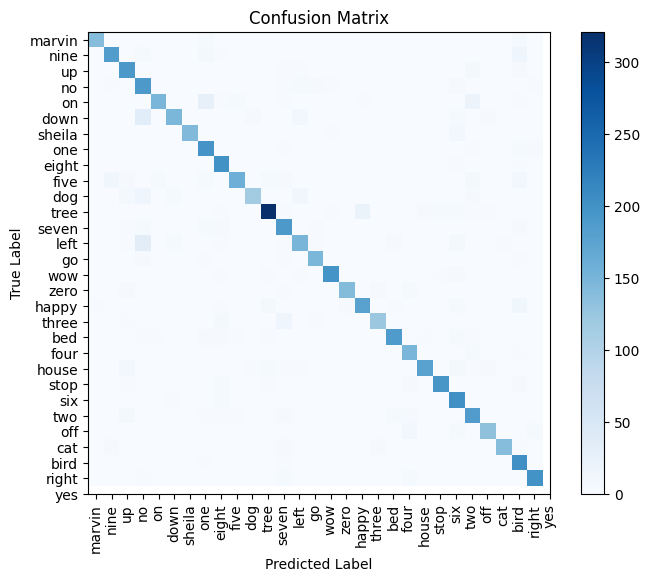

In [22]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Set tick labels
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels, rotation=0)
plt.show()

# Experiments Pipeline


## Functions and classes

In [12]:
class AugmentationTechnique(Enum):
    NoAugmentation = 0
    Tempo = 1
    Echo = 2
    Noise = 3

class ModelType(Enum):
    LSTM =1
    Transformer = 2

class OptimizerType(Enum):
    Adam = 1
    Sgd=2
    Lion=3
class RegularizationType(Enum):
    NoRegularization = 1
    L2 =2
    Dropout=3
def getRegularizer(regularizerType,value):
    match regularizerType:
        case RegularizationType.L2:
            return L2(value)
def getDenseLayer(model,regularization, activation,nodes):
        match regularization['type']:
            case RegularizationType.Dropout:
                model.add(Dropout(rate=regularization['value']))
                model.add(Dense(nodes, activation=activation))
            case RegularizationType.NoRegularization:
                model.add(Dense(nodes, activation=activation))
            case RegularizationType.L2:
                model.add(Dense(nodes, activation=activation, kernel_regularizer=getRegularizer(regularizerType=regularization['type'],value=regularization['value'])))
def getAugmentationLayer(model,technique, seed):
    match technique:
        case AugmentationTechnique.NoAugmentation:
            return;


class Model:
    def fit(self,batch_size,epochs,train_images,train_labels,valid_images,valid_labels):
        pass
    def predict(self,test_images):
        pass
    def __init__(self,optimizer,loss,metrics):
        pass

class CustomLSTM(Model):
    def __init__(self,optimizer,loss,metrics,regularizer,seed,augmentation,num_classes):
        self.model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Reshape((-1, 128)),
            LSTM(128),
            Dense(num_classes, activation='softmax')
        ])
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self,batch_size,epochs,train_dataset,val_dataset):
        return self.model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=val_dataset)

    def predict(self,test_df):
        result=self.model.predict(test_df)
        return np.argmax(result,axis=1)




In [13]:
def createModel(modelType, optimizer, loss, metrics, regularizer,seed,augmentation,num_classes)->Model:
    match modelType:
        case ModelType.LSTM:
            return CustomLSTM(optimizer=optimizer,loss=loss,metrics=metrics,regularizer=regularizer,seed=seed,augmentation=augmentation,num_classes=num_classes)



def getOptimizer(optimizer_type, learningRate):
    match optimizer_type:
        case OptimizerType.Adam:
            return Adam(learning_rate=learningRate)
        case OptimizerType.Sgd:
            return SGD(learning_rate=learningRate)
        case OptimizerType.Lion:
            return Lion(learning_rate=learningRate)

In [14]:
def create_dataset_lstm(df, num_classes, batch_size):
    def generator():
        for index, row in df.iterrows():
            img, label = preprocess_data(row, num_classes)
            yield img, label

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32), tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)))
    # dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(2)
    return dataset

def getDatasetGenerator(modelType,df,num_classes,batch_size):
    match(modelType):
        case ModelType.LSTM:
            return create_dataset_lstm(df,num_classes,batch_size)


In [15]:
def reduceDataset(df,percentToKeep):
    return df.groupby('label').head(int(df.shape[0]*float(percentToKeep/100)/num_classes)).reset_index(drop=True)

In [16]:
def performSingleExperiment(modelType, batchSize, epochNumber, augmentation, learningRate, seed, optimizerType,num_classes,train_data,val_data,test_split_dataset,split, regularizer):
    # print(f"Performing experiment with model: {modelType}, batch size: {batchSize}, epochs: {epochNumber}, augmentation: {augmentation}, regularizer: {regularizer}, learning rate: {learningRate}, seed: {seed}")
    print(f"Performing experiment with model: {modelType}, batch size: {batchSize}, epochs: {epochNumber}, augmentation: {augmentation}, regularization: {regularizer['type'].name},learning rate: {learningRate}, seed: {seed}, optimizer: {optimizerType.name}, split: {split}")
    set_seed(seed)
    # TODO: Increase the size of used dataset to 10% or even 20%
    train_dataset = getDatasetGenerator(modelType,reduceDataset(train_data,20), num_classes, batchSize)
    val_dataset = getDatasetGenerator(modelType,reduceDataset(val_data,20), num_classes, batchSize)
    model = createModel(num_classes=num_classes,modelType=modelType,regularizer={"type":regularizer['type'],"value":regularizer['value']},optimizer=getOptimizer(optimizer_type=optimizerType,learningRate=learningRate), loss='categorical_crossentropy', metrics=['accuracy'],seed=seed, augmentation=augmentation)
    # train the model
    history = model.fit(batch_size=batchSize,epochs=epochNumber, train_dataset=train_dataset,val_dataset=val_dataset)

    # get accuracy
    test_split_dataset_generator = getDatasetGenerator(modelType,test_split_dataset, num_classes, batchSize)
    y_pred = model.predict(test_split_dataset_generator)
    y_true = []
    for index, row in test_split_dataset.iterrows():
        y_true.append(row['label'])

    accuracy = accuracy_score(y_true, y_pred)
    # TODO: Update this, make sure it can be easily transformed to a dataframe, also add all parameters
    return [accuracy, augmentation,optimizerType,batchSize,learningRate,epochNumber, seed,split,regularizer,modelType], history


def performExperiment(batchSizes, learningRates, numberOfEpochs, augmentationTechniques, regularizers,modelType,seeds,optimizers,num_classes, trainData, splits):
    results = []
    histories = []
    accuracy=0
    accuracyMean = 0
    accuracyArray=[]
    train_split_dataset, val_split_dataset = train_test_split(trainData, stratify=trainData['label'], test_size=0.1)
    train_split_dataset, test_split_dataset = train_test_split(train_split_dataset, stratify=train_split_dataset['label'], test_size=splits[0])


    currentBestBatchSize = batchSizes[0]
    currentBestLearningRate = learningRates[0]
    currentBestNumberOfEpochs = 10
    lastExperimentNumberOfEpochs = 50
    currentBestAugmentation =augmentationTechniques[0]
    currentBestOptimizer = optimizers[0]
    currentBestSplit = splits[0]
    currentBestRegularizer = regularizers[0]
    bestSeed=seeds[0]
    tempSeed=seeds[0]
    bestSeedAccuracy=0
    tempSeedAccuracy=0

    for seed in seeds:

        result,history=performSingleExperiment(regularizer=currentBestRegularizer,split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,seed=seed,optimizerType=currentBestOptimizer)
        results.append(result)
        accuracyArray.append(result[0])
    accuracyMean=np.mean(accuracyArray)
    bestSeedAccuracy=accuracyArray[0]
    accuracyArray=[]



    for augmentation in augmentationTechniques:
        for seed in seeds:
            result,history=performSingleExperiment(regularizer=currentBestRegularizer,split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=augmentation,seed=seed,optimizerType=currentBestOptimizer)
            result.append('augmentation')
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray)>accuracyMean:
            currentBestAugmentation=augmentation
            accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]




    for optimizer in optimizers:
        for learningRate in learningRates:
            for seed in seeds:
                result,history=performSingleExperiment(regularizer=currentBestRegularizer,split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=learningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,seed=seed,optimizerType=optimizer)
                result.append('optimizer-learning rate')
                results.append(result)
                accuracyArray.append(result[0])
            if np.mean(accuracyArray)>accuracyMean:
                currentBestLearningRate=learningRate
                currentBestOptimizer=optimizer
                accuracyMean=np.mean(accuracyArray)

            accuracyArray=[]


    for batchSize in batchSizes:
        for seed in seeds:
            result,history=performSingleExperiment(regularizer=currentBestRegularizer,split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=batchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,seed=seed,optimizerType=currentBestOptimizer)
            result.append('batch size')
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray)>accuracyMean:
            currentBestBatchSize=batchSize
            accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]


    for split in splits:
        for seed in seeds:
            set_seed(seed)
            train_split_dataset, val_split_dataset = train_test_split(trainData, stratify=trainData['label'], test_size=0.1)
            train_split_dataset, test_split_dataset = train_test_split(train_split_dataset, stratify=train_split_dataset['label'], test_size=split)

            result,history=performSingleExperiment(regularizer=currentBestRegularizer,split=split,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,seed=seed,optimizerType=currentBestOptimizer)
            result.append('split')
            results.append(result)
            if tempSeedAccuracy<result[0]:
                tempSeed=seed
                tempSeedAccuracy=result[0]
            accuracyArray.append(result[0])

        if np.mean(accuracyArray)>accuracyMean:
            bestSeed=tempSeed
            bestSeedAccuracy=tempSeedAccuracy
            currentBestSplit=split
            accuracyMean=np.mean(accuracyArray)
        tempSeedAccuracy=0

        accuracyArray=[]

    result,history=performSingleExperiment(regularizer=currentBestRegularizer,split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=lastExperimentNumberOfEpochs,augmentation=currentBestAugmentation,seed=seed,optimizerType=currentBestOptimizer)
    accuracy = result[0]
    results.append(result)
    histories.append(history)



    return results, [accuracy,currentBestBatchSize, currentBestLearningRate,currentBestNumberOfEpochs, currentBestAugmentation,currentBestOptimizer,currentBestSplit,currentBestRegularizer,modelType,bestSeed], histories

In [17]:
def performExperimentsOnModel(modelType):
    results, best, histories = performExperiment(modelType=ModelType.LSTM,batchSizes=batchSizes,learningRates=learningRates,numberOfEpochs=numberOfEpochs,augmentationTechniques=augmentationTechniques,regularizers=regularizers,seeds=seeds, optimizers=optimizers,num_classes=num_classes, splits=splits, trainData=data)
    print(results)
    print(best)
    print(histories)

    return results, best, histories

## Parameters

In [18]:
# training process
batchSizes =[128,64,32]
#batchSizes = [64]
learningRates = [0.01,0.001,0.0001]
#learningRates=[0.001]
#numberOfEpochs =[5,10,15]
numberOfEpochs=[10]

# regularization
#regularizers = [{"type":RegularizationType.NoRegularization,"value":0},{"type":RegularizationType.Dropout,"value":0.5},{"type":RegularizationType.L2,"value":0.01}]
#regularizers=[{"type":RegularizationType.NoRegularization,"value":0},{"type":RegularizationType.Dropout,"value":0.3},{"type":RegularizationType.Dropout,"value":0.5},{"type":RegularizationType.Dropout,"value":0.8},{"type":RegularizationType.L2,"value":0.001},{"type":RegularizationType.L2,"value":0.01},{"type":RegularizationType.L2,"value":0.1}]
regularizers = [{"type":RegularizationType.NoRegularization,"value":0}]
seeds = [123,42,9,13,4]
#splits = [0.1, 0.2, 0.3]
#seeds=[42]
splits=[0.1,0.2,0.3]
#splits=[0.1]
models = [ModelType.LSTM]

optimizers = [OptimizerType.Adam, OptimizerType.Sgd, OptimizerType.Lion]
#optimizers=[OptimizerType.Adam]
# augmentation
augmentationTechniques =[AugmentationTechnique.NoAugmentation]
#augmentationTechniques=[AugmentationTechnique.Flipping]

## Process

### LSTM - artificially removed background noise

In [30]:
modelType=ModelType.LSTM

In [31]:
%%time
results, best, histories =performExperimentsOnModel(modelType)

Performing experiment with model: ModelType.LSTM, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularization: NoRegularization,learning rate: 0.01, seed: 123, optimizer: Adam, split: 0.1
Epoch 1/10
80/80 [==============================] - 19s 207ms/step - loss: 2.9286 - accuracy: 0.1489 - val_loss: 6.0628 - val_accuracy: 0.0890
Epoch 2/10
80/80 [==============================] - 16s 198ms/step - loss: 2.6012 - accuracy: 0.2567 - val_loss: 4.2380 - val_accuracy: 0.1508
Epoch 3/10
80/80 [==============================] - 16s 199ms/step - loss: 2.1801 - accuracy: 0.3565 - val_loss: 3.3840 - val_accuracy: 0.2229
Epoch 4/10
80/80 [==============================] - 16s 196ms/step - loss: 1.9110 - accuracy: 0.4231 - val_loss: 2.6786 - val_accuracy: 0.2654
Epoch 5/10
80/80 [==============================] - 16s 197ms/step - loss: 1.7583 - accuracy: 0.4651 - val_loss: 2.3428 - val_accuracy: 0.3424
Epoch 6/10
80/80 [==============================] - 16s 199ms

In [32]:
titleComment=' - artificial'
with open("results-"+str(modelType.name)+titleComment,"wb") as my_csv:
    pickle.dump(results,my_csv)
with open("best-"+str(modelType.name)+titleComment,"wb") as my_csv:
    pickle.dump(best,my_csv)
with open("histories-"+str(modelType.name)+titleComment,"wb") as my_csv:
    pickle.dump(histories,my_csv)
if IS_IN_COLAB:
    shutil.copy("/content/results-"+str(modelType.name)+titleComment, "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    shutil.copy("/content/best-"+str(modelType.name)+titleComment, "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    shutil.copy("/content/histories-"+str(modelType.name)+titleComment, "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")


# Results

## Functions

In [19]:
def process50EpochsResults(results,best,histories,model,titleComment):
    # Plot training and validation accuracy
    plt.plot(histories[len(histories)-1].history['accuracy'], label='Training Accuracy')
    plt.plot(histories[len(histories)-1].history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    title='50 epochs Training and Validation Accuracy '+str(model.name)+titleComment
    plt.title(title)
    plt.legend()

    plt.savefig(str(model.name)+"-50epochs-TrainingandValidationLoss.png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+str(model.name)+"-50epochs-TrainingandValidationLoss.png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Plot training and validation loss
    plt.plot(histories[len(histories)-1].history['loss'], label='Training Loss')
    plt.plot(histories[len(histories)-1].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    title='50 epochs Training and Validation Loss '+str(model.name)+titleComment

    plt.title(title)
    plt.legend()

    plt.savefig(title+".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+".png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()



In [20]:
def finalModelTest(createModelArgs,fitModelArgs,testData,y_true, titleComment):
    model = createModel(**createModelArgs)
    # train the model
    history = model.fit(**fitModelArgs)


    # get accuracy
    y_pred = model.predict(testData)


    accuracy = accuracy_score(y_true, y_pred)

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    title = createModelArgs['modelType'].name+' - Training and Validation Accuracy'+titleComment
    plt.title(title)
    plt.legend()
    plt.savefig(title+".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+".png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    title = createModelArgs['modelType'].name+' - Training and Validation Loss'+titleComment

    plt.title(title)
    plt.legend()
    plt.savefig(title+".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+".png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()


    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_mat, cmap=plt.cm.Blues)
    title = createModelArgs['modelType'].name+' - Confusion Matrix'+titleComment

    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Set tick labels
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.yticks(np.arange(len(labels)), labels, rotation=0)
    plt.savefig(title+".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+".png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()




In [21]:
def processParametersResults(results,model, titleComment):
    resultsDf = pd.DataFrame(results,columns=['accuracy','augmentation','optimizer','batch size','learning rate','number of epochs','seed','split','regularizer','model','section'])
    resultsDf['optimizer']=resultsDf['optimizer'].apply(lambda x: x.name)
    resultsDf['augmentation']=resultsDf['augmentation'].apply(lambda x: x.name)

    # Optimizer type and learning rate

    sns.boxplot(data=resultsDf,x='optimizer',y='accuracy',hue='learning rate')
    title=str(model.name)+' - Accuracy per optimzier per learning rate'+titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png', format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+'.png', "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Batch size

    sns.boxplot(data=resultsDf,x='batch size',y='accuracy')
    title=str(model.name)+' - Accuracy per batch size'+titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png', format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+'.png', "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Split
    sns.boxplot(data=resultsDf,x='split',y='accuracy')
    title=str(model.name)+' - Accuracy per split'+titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png', format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+'.png', "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()


In [22]:
def processParametersFilteredResults(results,model, titleComment,best):
    resultsDf = pd.DataFrame(results,columns=['accuracy','augmentation','optimizer','batch size','learning rate','number of epochs','seed','split','regularizer','model','section'])
    resultsDf['optimizer']=resultsDf['optimizer'].apply(lambda x: x.name)
    resultsDf['augmentation']=resultsDf['augmentation'].apply(lambda x: x.name)


    bestDf = pd.DataFrame([best],columns=['accuracy','batch size','learning rate','epochs','augmentation','optimizer','split','regularizer','model','seed'])

    # Optimizer type and learning rate

    sns.boxplot(data=resultsDf[resultsDf['section']=='optimizer-learning rate'],x='optimizer',y='accuracy',hue='learning rate')
    title=str(model.name)+' - Accuracy per optimzier per learning rate - filtered'+titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png', format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+'.png', "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Batch size

    sns.boxplot(data=resultsDf[resultsDf['section']=='batch size'],x='batch size',y='accuracy')
    title=str(model.name)+' - Accuracy per batch size - filtered'+titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png', format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+'.png', "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Split
    sns.boxplot(data=resultsDf[resultsDf['section']=='split'],x='split',y='accuracy')
    title=str(model.name)+' - Accuracy per split - filtered'+titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png', format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+'.png', "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

## LSTM - artificially removed background noise

In [24]:
model=ModelType.LSTM
titleComment = ' - artificial'

with open(r"/content/results-"+str(model.name)+titleComment, "rb") as input_file:
    results = pickle.load(input_file)

with open(r"/content/best-"+str(model.name)+titleComment, "rb") as input_file:
    best = pickle.load(input_file)

with open(r"/content/histories-"+str(model.name)+titleComment, "rb") as input_file:
    histories = pickle.load(input_file)

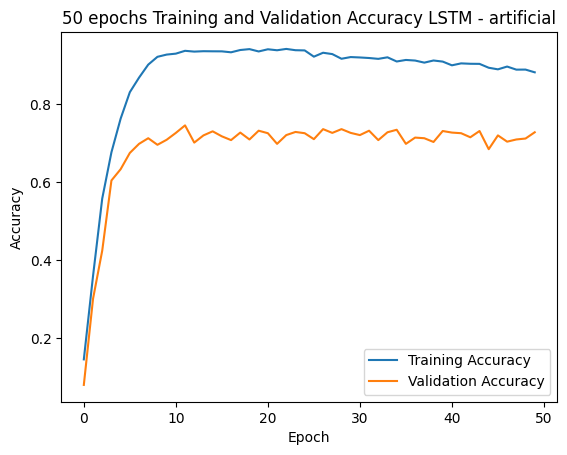

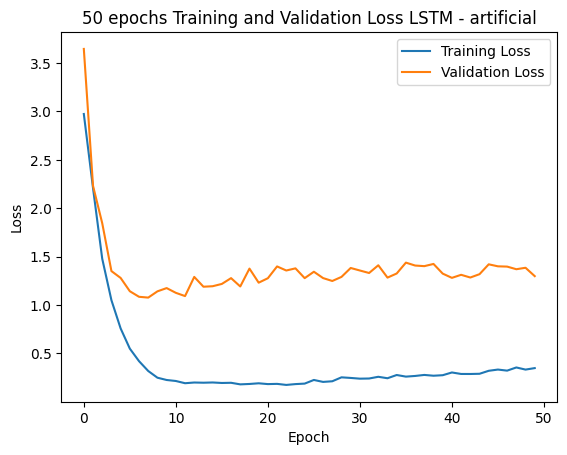

In [38]:
process50EpochsResults(results,best,histories,model, titleComment)

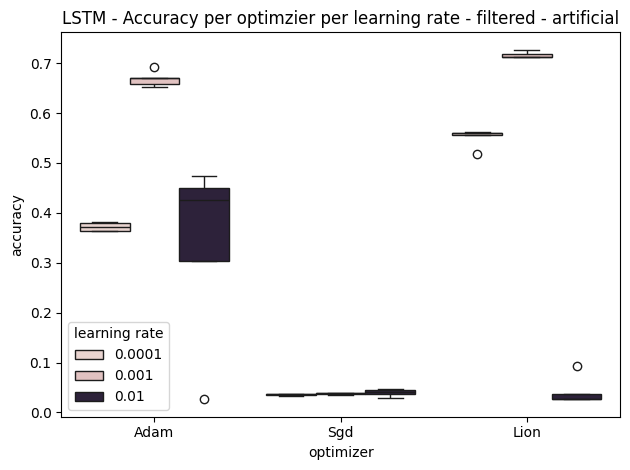

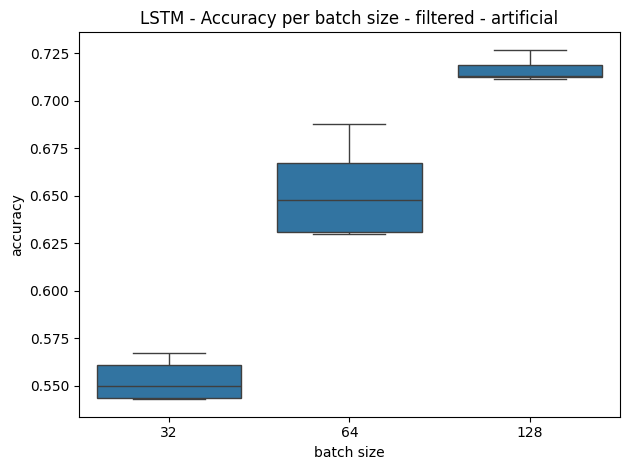

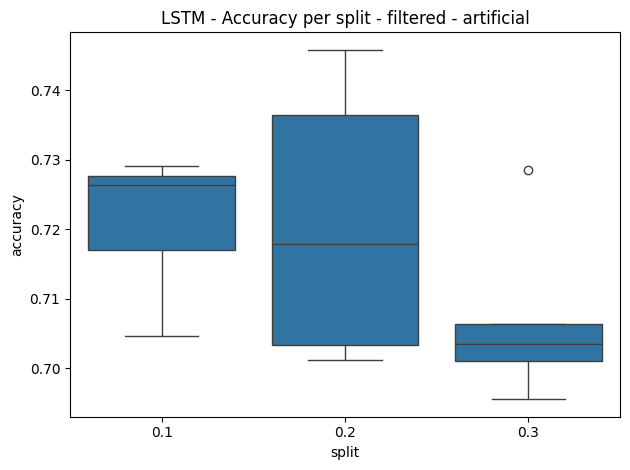

In [39]:
processParametersFilteredResults(results,model, titleComment,best)

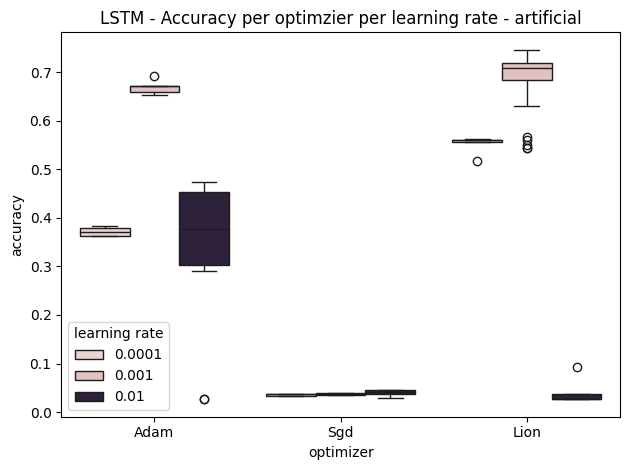

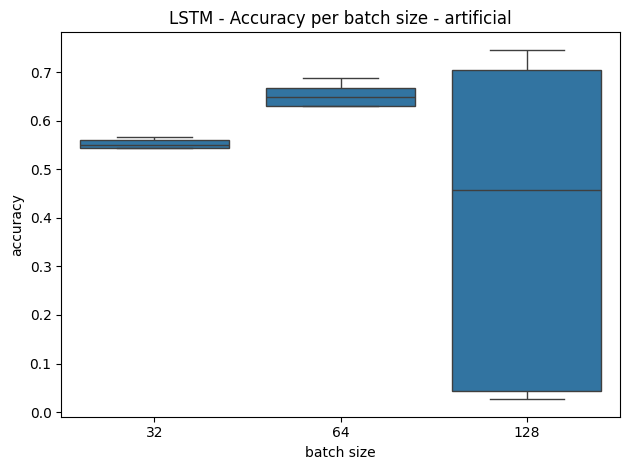

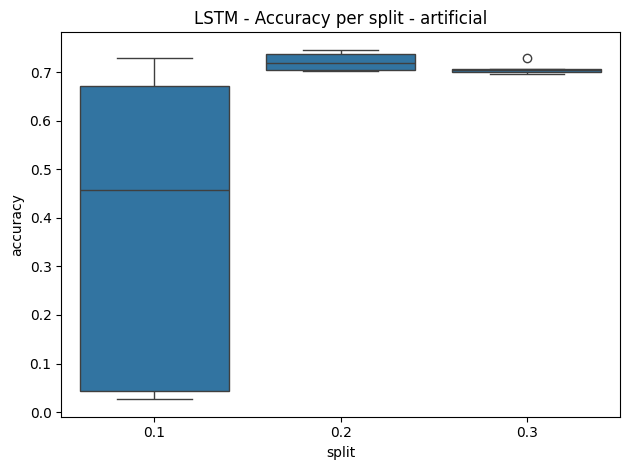

In [40]:
processParametersResults(results,model, titleComment)

In [25]:
bestDf = pd.DataFrame([best],columns=['accuracy','batch size','learning rate','epochs','augmentation','optimizer','split','regularizer','model','seed'])

In [26]:
bestDf.head()

,accuracy,batch size,learning rate,epochs,augmentation,optimizer,split,regularizer,model,seed
0,0.691559,128,0.001,10,AugmentationTechnique.NoAugmentation,OptimizerType.Lion,0.1,"{'type': RegularizationType.NoRegularization, ...",ModelType.LSTM,4


In [27]:
batchSize=bestDf['batch size'][0]

set_seed(42)
train_split_dataset, val_split_dataset = train_test_split(data, stratify=data['label'], test_size=0.1)
train_split_dataset, test_split_dataset = train_test_split(train_split_dataset, stratify=train_split_dataset['label'], test_size=bestDf['split'][0])
# TODO: Use the whole dataset instead
# train_split_dataset.head(int(len(train_split_dataset)/20))
trainDataGenerator = getDatasetGenerator(model,train_split_dataset, num_classes, batchSize)
valDataGenerator = getDatasetGenerator(model,val_split_dataset, num_classes, batchSize)
testDataGenerator = getDatasetGenerator(model,test_split_dataset, num_classes, batchSize)

y_true = []
for index, row in test_split_dataset.iterrows():
    y_true.append(row['label'])

# Switching to Adam instead of Lion, on larger dataset Adam seems to be better
createModelArgs={'modelType':model,'optimizer':getOptimizer(optimizer_type=OptimizerType.Adam,learningRate=bestDf['learning rate'][0]),'regularizer':{"type":bestDf['regularizer'][0]['type'],"value":bestDf['regularizer'][0]['value']},'loss':'categorical_crossentropy','metrics':['accuracy'],'augmentation':bestDf['augmentation'][0],'seed':bestDf['seed'][0],'num_classes':num_classes}
fitModelArgs = {'batch_size':batchSize,'epochs':10,'train_dataset':trainDataGenerator,'val_dataset':valDataGenerator}



Epoch 1/10
410/410 [==============================] - 114s 235ms/step - loss: 1.7301 - accuracy: 0.4956 - val_loss: 0.8773 - val_accuracy: 0.7437
Epoch 2/10
410/410 [==============================] - 96s 234ms/step - loss: 0.7302 - accuracy: 0.7831 - val_loss: 0.6215 - val_accuracy: 0.8183
Epoch 3/10
410/410 [==============================] - 96s 235ms/step - loss: 0.5377 - accuracy: 0.8374 - val_loss: 0.5558 - val_accuracy: 0.8347
Epoch 4/10
410/410 [==============================] - 96s 235ms/step - loss: 0.4382 - accuracy: 0.8680 - val_loss: 0.5256 - val_accuracy: 0.8441
Epoch 5/10
410/410 [==============================] - 96s 235ms/step - loss: 0.3769 - accuracy: 0.8855 - val_loss: 0.4867 - val_accuracy: 0.8563
Epoch 6/10
410/410 [==============================] - 96s 235ms/step - loss: 0.3281 - accuracy: 0.9012 - val_loss: 0.4999 - val_accuracy: 0.8543
Epoch 7/10
410/410 [==============================] - 97s 236ms/step - loss: 0.2881 - accuracy: 0.9125 - val_loss: 0.5170 - val_a

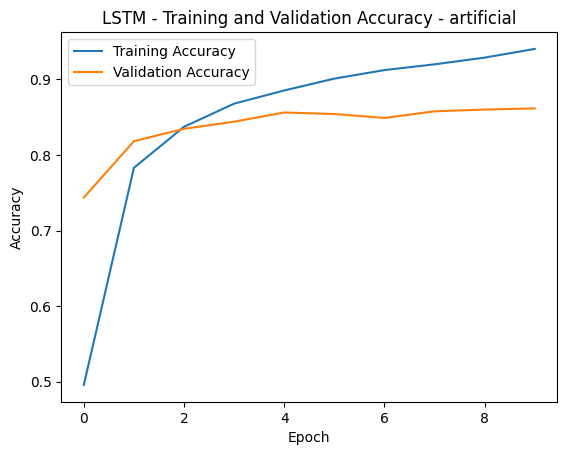

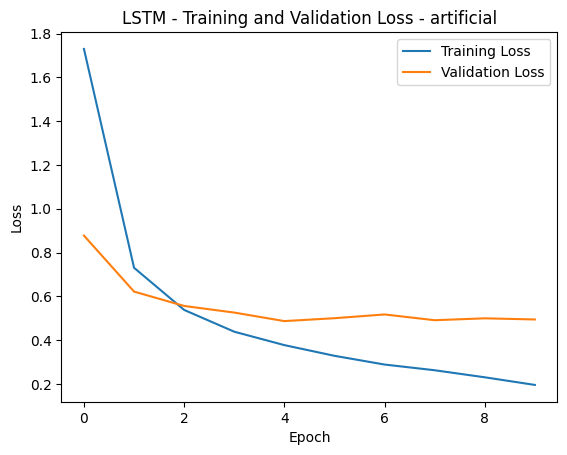

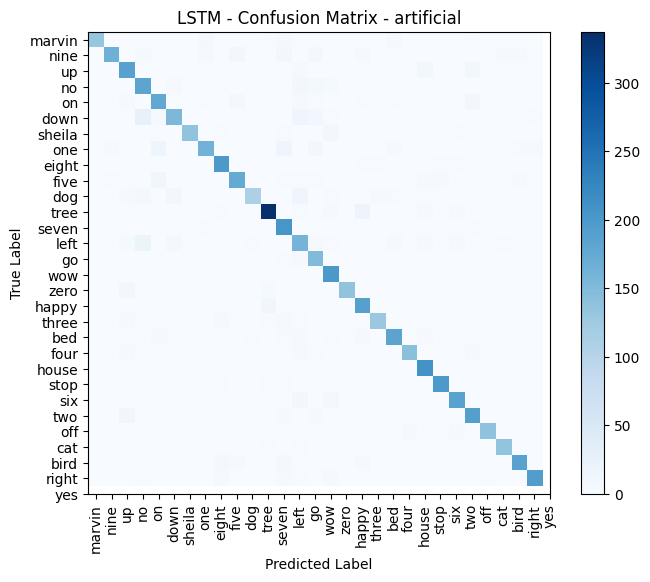

CPU times: user 16min 5s, sys: 59 s, total: 17min 4s
Wall time: 16min 31s


In [28]:
%%time
finalModelTest(createModelArgs,fitModelArgs,testDataGenerator,y_true, titleComment)

# CAREFUL: Disconnect from colab

In [ ]:
if IS_IN_COLAB:
  from google.colab import runtime
  runtime.unassign()